In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model("/content/drive/My Drive/stacked-bi-lstm.h5")
model2 = load_model("/content/drive/My Drive/stacked-bi-gru.h5")
model3 = load_model("/content/drive/My Drive/parallel-bi-lstm-bi-gru.h5")

In [ ]:
import json
from tensorflow.keras.models import model_from_json

with open("/content/drive/My Drive/clip_model_nn.json", "r") as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/content/drive/My Drive/clip_model_nn.h5")


In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^A-Za-z]', ' ', text)
    text = text.lower()
    return text
tokenizer = Tokenizer()

In [ ]:
import pandas as pd
import json
import os

# Load dataset from JSONL file
def load_dataset(file_path):
    dataset = []
    with open(file_path, 'r') as file:
        for line in file:
            example = json.loads(line)
            dataset.append(example)
    return dataset

# Define file paths
train_file = '/content/drive/My Drive/Hateful-memes/data/train.jsonl'
image_directory = '/content/drive/My Drive/Hateful-memes/data/'

train_dataset = load_dataset(train_file)

chosen_examples = train_dataset

# Create DataFrame
data = []
for idx, example in enumerate(chosen_examples):
    text = example['text']
    img_path = os.path.join(image_directory, example['img'])
    label = example['label']
    data.append({'id': idx, 'img_text': text, 'img_path': img_path, 'label': label})

df = pd.DataFrame(data)

# Display DataFrame
print(df.head())

   id                                           img_text  \
0   0   its their character not their color that matters   
1   1  don't be afraid to love again everyone is not ...   
2   2                           putting bows on your pet   
3   3  i love everything and everybody! except for sq...   
4   4  everybody loves chocolate chip cookies, even h...   

                                            img_path  label  
0  /content/drive/My Drive/Hateful-memes/data/img...      0  
1  /content/drive/My Drive/Hateful-memes/data/img...      0  
2  /content/drive/My Drive/Hateful-memes/data/img...      0  
3  /content/drive/My Drive/Hateful-memes/data/img...      0  
4  /content/drive/My Drive/Hateful-memes/data/img...      0  


In [ ]:
def extract_features(df, feature_extractor_model, tokenizer, max_sequence_length=128):
    preprocessed_texts = [preprocess_text(text) for text in df['img_text']]
    tokenized_texts = tokenizer.texts_to_sequences(preprocessed_texts)
    padded_texts = pad_sequences(tokenized_texts, maxlen=max_sequence_length, padding='post', truncating='post')
    features = feature_extractor_model.predict(padded_texts)
    return features

In [ ]:
from tensorflow.keras.models import Model

# Remove the second-to-last layer (the dropout layer)
feature_extractor_model = Model(inputs=model1.input, outputs=model1.layers[-3].output)

In [ ]:
from tensorflow.keras.models import Model

# Remove the second-to-last layer (the dropout layer)
feature_extractor_model2 = Model(inputs=model2.input, outputs=model2.layers[-3].output)

In [ ]:
from tensorflow.keras.models import Model

# Remove the second-to-last layer (the dropout layer)
feature_extractor_model3 = Model(inputs=model3.input, outputs=model3.layers[-3].output)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_model.to(device)

checkpoint = torch.load("/content/drive/MyDrive/bert_hs.pth", map_location=device)
bert_model.load_state_dict(checkpoint)

bert_model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cpu")
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

def extract_featuresb(text):

    text=preprocess_text(text)

    tokenized_text = bert_tokenizer.encode(text, add_special_tokens=True, max_length=128, truncation=True, padding='max_length')

    input_ids = torch.tensor([tokenized_text]).to(device)

    with torch.no_grad():
        bert_model.eval()
        outputs = bert_model(input_ids)
        encoder_outputs = outputs.last_hidden_state

    return encoder_outputs


In [ ]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9ga9olq1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9ga9olq1
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
import clip

available_models = clip.available_models()

print(available_models)


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [ ]:
import clip
from PIL import Image
import numpy as np

# Load the CLIP model and processor
model, preprocess = clip.load("ViT-B/32")


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 111MiB/s]


In [ ]:
def extract_featuresi(image_path):
    image = Image.open(image_path)

    image_input = preprocess(image).unsqueeze(0)

    with torch.no_grad():
        image_features = model.encode_image(image_input)

    image_features = image_features.cpu().numpy()

    return image_features

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

def extract_load_featuresi(img_array):

    image = array_to_img(img_array)

    image_input = preprocess(image).unsqueeze(0)

    with torch.no_grad():
        image_features = model.encode_image(image_input)

    image_features = image_features.cpu().numpy()

    return image_features

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3fab6921650526efc704cc75dd074954be30d8759be4a694133cbfde37b91312
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer


In [ ]:
explainert = LimeTextExplainer(class_names=['hate'])

In [ ]:
import lime
from lime import lime_image
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
def predict_proba(texts):
    predictions_list = []

    print(len(texts))

    tokenizer = Tokenizer()
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    for text in texts:

        print(text)

        tokenizer = Tokenizer()

        tokenized_text = tokenizer.texts_to_sequences([text])
        padded_text = pad_sequences(tokenized_text, maxlen=128, padding='post', truncating='post')

        features1 = feature_extractor_model.predict(padded_text)
        features2 = feature_extractor_model2.predict(padded_text)
        features3 = feature_extractor_model3.predict(padded_text)

        featuresb = extract_featuresb(text)

        featuresb = (featuresb,)

        concatenated_features = torch.cat(featuresb, dim=0)

        features_array = concatenated_features.cpu().numpy()

        mean_features_list = np.mean(features_array, axis=1)

        mean_features_list = np.resize(mean_features_list, (1, 800))

        weighted_features = 0.7 * mean_features_list + 0.1 * features1 + 0.1 * features2 + 0.1 * features3

        concatenated_features = np.concatenate((weighted_features, [features[0]]), axis=1)

        print(concatenated_features.shape)

        prediction = loaded_model.predict(concatenated_features)

        print(prediction[0])

        predictions_list.append(prediction.flatten())

    return np.array(predictions_list)


        id                                           img_text  \
8404  8404  "do you like your juice cold?" "no, i like my ...   

                                               img_path  label  
8404  /content/drive/My Drive/Hateful-memes/data/img...      1  
8404    /content/drive/My Drive/Hateful-memes/data/img...
Name: img_path, dtype: object
 do you like your juice cold    no  i like my jews well done 
/content/drive/My Drive/Hateful-memes/data/img/75349.png
(1, 512)


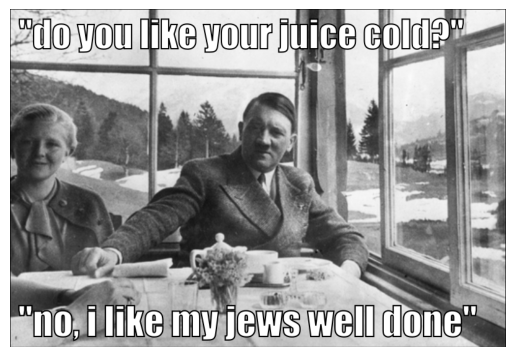

In [ ]:
row = df[df['id'] == 8404]

print(row)
print(row['img_path'])

text = preprocess_text(row['img_text'].values[0])
image_path = row['img_path'].values[0]

features = extract_featuresi(image_path)

print(text)
print(image_path)
print(features.shape)

from matplotlib import pyplot as plt

image = plt.imread(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
# Get the explanation
explanationt = explainert.explain_instance(text, predict_proba, num_features=10, top_labels=1,num_samples=100)

100
 do you like your juice cold    no  i like my jews well done 
1/1 [==============================] - 0s 65ms/step
(1, 1312)
1/1 [==============================] - 0s 21ms/step
[0.75055516]
                  
1/1 [==============================] - 0s 78ms/step
(1, 1312)
1/1 [==============================] - 0s 20ms/step
[0.75073856]
 do                 
1/1 [==============================] - 0s 65ms/step
(1, 1312)
1/1 [==============================] - 0s 20ms/step
[0.7497314]
                  
1/1 [==============================] - 0s 71ms/step
(1, 1312)
1/1 [==============================] - 0s 26ms/step
[0.75073856]
 do you like your juice cold    no  i like my  well done 
1/1 [==============================] - 0s 66ms/step
(1, 1312)
1/1 [==============================] - 0s 28ms/step
[0.7504175]
 do you  your  cold      i  my  well  
1/1 [==============================] - 0s 129ms/step
(1, 1312)
1/1 [==============================] - 0s 33ms/step
[0.75125337]
                 

In [ ]:
# Visualize the explanation
explanationt.show_in_notebook(text=True)

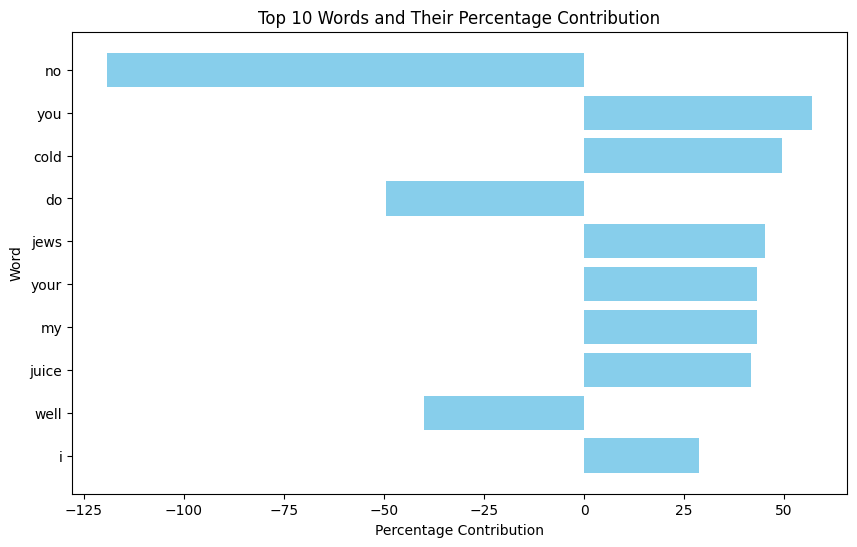

In [ ]:
import matplotlib.pyplot as plt

# Get the feature importance and words from the explanation
word_importance = explanationt.as_list(label=0)
words = [word for word, _ in word_importance]
importance_scores = [score for _, score in word_importance]

# Normalize importance scores to get percentage contribution
total_importance = sum(importance_scores)
percentage_contributions = [(score / total_importance) * 100 for score in importance_scores]

# Plot the percentage contributions
plt.figure(figsize=(10, 6))
plt.barh(words, percentage_contributions, color='skyblue')
plt.xlabel('Percentage Contribution')
plt.ylabel('Word')
plt.title('Top 10 Words and Their Percentage Contribution')
plt.gca().invert_yaxis()
plt.show()


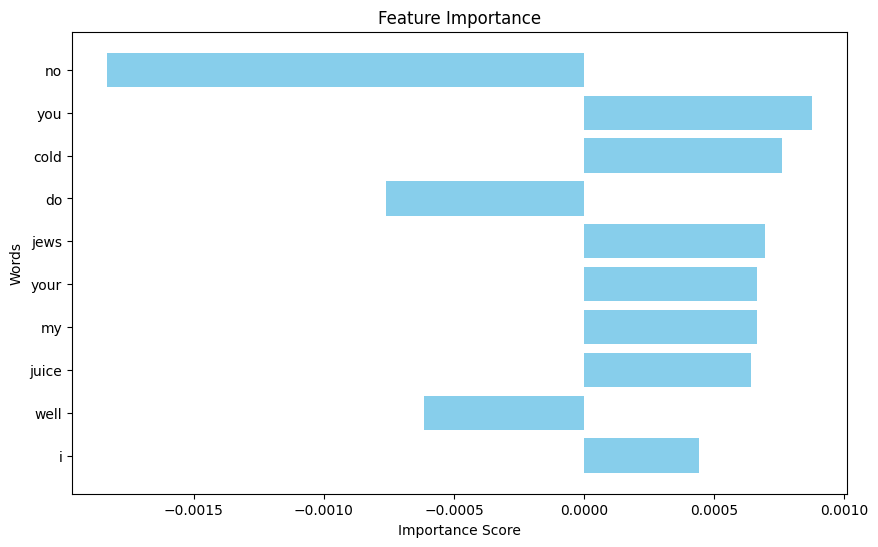

In [ ]:
import matplotlib.pyplot as plt

# Get the feature importance and words from the explanation
word_importance = explanationt.as_list(label=0)
words = [word for word, _ in word_importance]
importance_scores = [score for _, score in word_importance]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.barh(range(len(words)), importance_scores, color='skyblue')
plt.yticks(range(len(words)), words)
plt.xlabel('Importance Score')
plt.ylabel('Words')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()


In [ ]:
print(words)
print(importance_scores)
print(percentage_contributions)

['no', 'you', 'cold', 'do', 'jews', 'your', 'my', 'juice', 'well', 'i']
[-0.0018317747271586085, 0.0008746481973733463, 0.0007601981061590501, -0.0007594875967850114, 0.0006966681289878373, 0.000665710780075122, 0.0006631377424501931, 0.0006427002068619235, -0.0006169264578315482, 0.00044198581692782177]
[-119.18941818277469, 56.91137027599966, 49.46436296634138, -49.41813173624004, 45.3306117446792, 43.31628741173507, 43.14886570155928, 41.81904171188444, -40.142002441840354, 28.759012548656056]


In [ ]:
def predict_probai(images):
    predictions_list = []

    print(len(images))

    for image in images:

        features = extract_load_featuresi(image)

        concatenated_features = np.concatenate((weighted_features, [features[0]]), axis=1)

        prediction = loaded_model.predict(concatenated_features)

        print(prediction[0])

        predictions_list.append(prediction[0])

    return np.array(predictions_list)

In [ ]:
tokenizer = Tokenizer()
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_text = tokenizer.texts_to_sequences([text])
padded_text = pad_sequences(tokenized_text, maxlen=128, padding='post', truncating='post')

features1 = feature_extractor_model.predict(padded_text)
features2 = feature_extractor_model2.predict(padded_text)
features3 = feature_extractor_model3.predict(padded_text)

featuresb = extract_featuresb(text)

featuresb = (featuresb,)

concatenated_features = torch.cat(featuresb, dim=0)

features_array = concatenated_features.cpu().numpy()

mean_features_list = np.mean(features_array, axis=1)

mean_features_list = np.resize(mean_features_list, (1, 800))

weighted_features = 0.7 * mean_features_list + 0.1 * features1 + 0.1 * features2 + 0.1 * features3

1/1 [==============================] - 0s 67ms/step


In [ ]:
# Create a LIME image explainer
explainer = lime_image.LimeImageExplainer()

In [ ]:
image = load_img(image_path)
img_array = img_to_array(image)

In [ ]:
# Get the explanation
explanation = explainer.explain_instance(img_array, predict_probai, top_labels=1, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

10
1/1 [==============================] - 0s 19ms/step
[0.75055516]
1/1 [==============================] - 0s 20ms/step
[0.60235953]
1/1 [==============================] - 0s 19ms/step
[0.74552596]
1/1 [==============================] - 0s 20ms/step
[0.8402304]
1/1 [==============================] - 0s 21ms/step
[0.387808]
1/1 [==============================] - 0s 24ms/step
[0.67390794]
1/1 [==============================] - 0s 20ms/step
[0.42386144]
1/1 [==============================] - 0s 20ms/step
[0.48693833]
1/1 [==============================] - 0s 20ms/step
[0.6886808]
1/1 [==============================] - 0s 19ms/step
[0.78226405]
10
1/1 [==============================] - 0s 34ms/step
[0.8277885]
1/1 [==============================] - 0s 29ms/step
[0.7718979]
1/1 [==============================] - 0s 28ms/step
[0.39242277]
1/1 [==============================] - 0s 30ms/step
[0.5867389]
1/1 [==============================] - 0s 31ms/step
[0.50625247]
1/1 [=====================

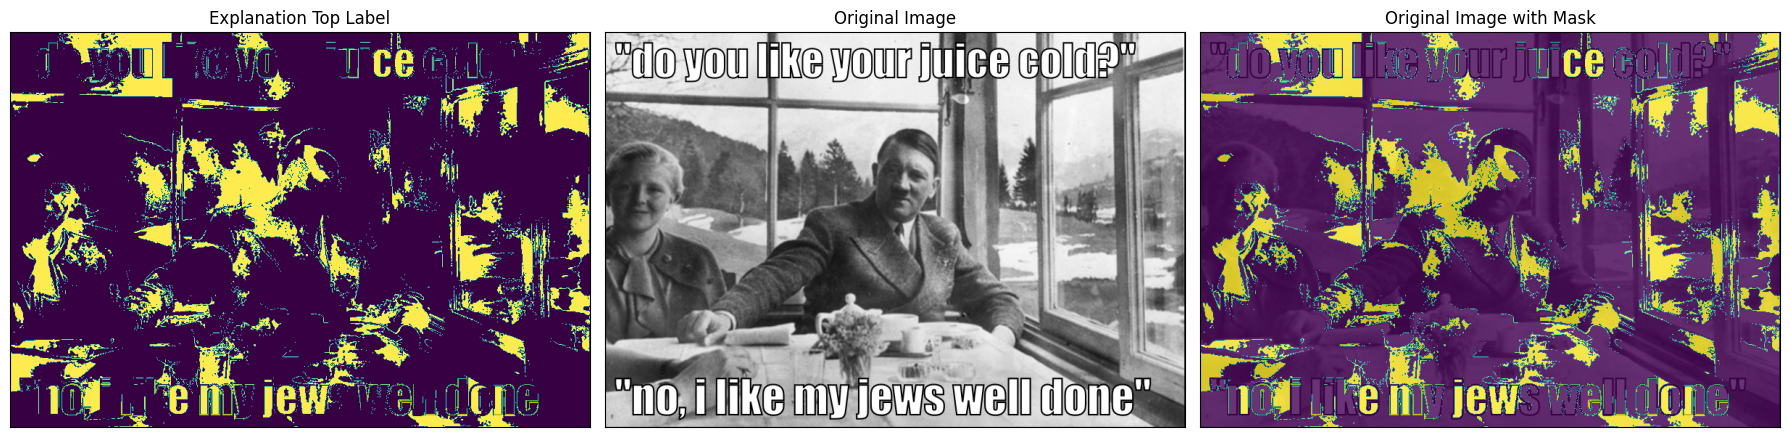

In [ ]:
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

imagex, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=200, hide_rest=True)

axs[0].imshow(imagex)
axs[0].imshow(mask, alpha=0.8)
axs[0].set_title('Explanation Top Label')

axs[1].imshow(image)
axs[1].set_title('Original Image')

axs[2].imshow(image)
axs[2].imshow(mask, alpha=0.8)
axs[2].set_title('Original Image with Mask')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


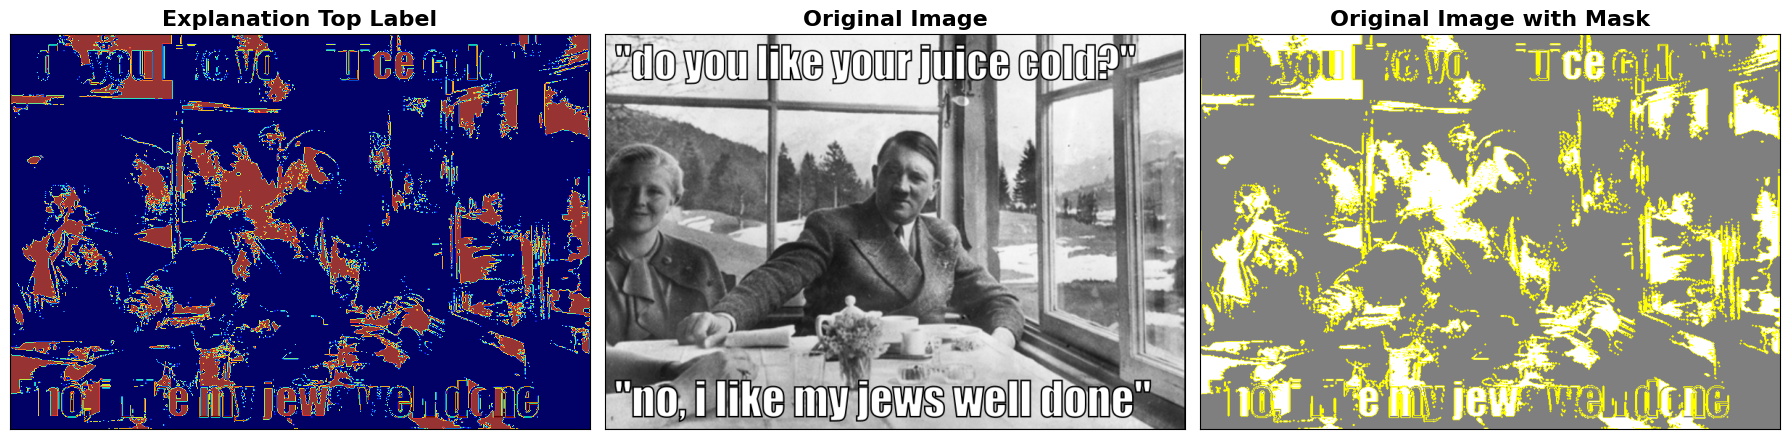

In [ ]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Get the image and mask from the explanation
imagex, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=200, hide_rest=True)

# Plot the explanation with the top label
axs[0].imshow(imagex)
axs[0].imshow(mask, alpha=0.8, cmap='jet')  # Use a colormap for the mask
axs[0].set_title('Explanation Top Label', fontsize=16, fontweight='bold')

# Plot the original image
axs[1].imshow(image)
axs[1].set_title('Original Image', fontsize=16, fontweight='bold')

# Plot the original image with the mask
axs[2].imshow(mark_boundaries(imagex/2 + 0.5, mask))
axs[2].set_title('Original Image with Mask', fontsize=16, fontweight='bold')

# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
len(explanation.segments)

545

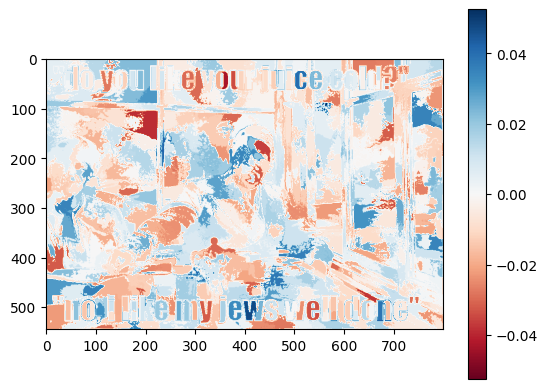

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()